# Accident response analysis

## How likely is it that a  🚓 officer will attend the scene of an accident?

Christian Lopez 😃


### How to use

Run these commands on your terminal of choice:

~~~bash
mkdir $HOME/github
cd
cd github
git clone https://github.com/LopezChris/challenge.git
jupyter notebook
~~~

finally select this notebook and run it

In [1]:
# Create pandas dataframes
import pandas as pd 
# Import data from local file system
import os
# Check if file exists
from os import path
# Plot graph
from matplotlib import pyplot as plt
# Heatmap
import seaborn as sns
# Display multiple lines
from IPython.display import display
# Dont show warning or deprication messages
import warnings
warnings.filterwarnings("ignore")
# Split data into train and test datasets
from sklearn.model_selection import train_test_split
# Random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
# Review results with a confusion matrix
from sklearn.metrics import confusion_matrix
# Show reports of trained model
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
# Upsampling to address the big difference in the data
from imblearn.over_sampling import SMOTE
from pathlib import Path
home = str(Path.home())
import math
import pickle

# Data Path
data_path="/github/h2o/input/DfTRoadSafety_Accidents_2014.csv"
# To save the model
filename='accident_police_present.sav'

### Data Exploration

First I will inspect the data in order to see if there are any null columns or values, I will also ensure that the data is in its proper format

In [2]:
# Read data from local file storage 
accidents = pd.read_csv(home + data_path)
# Sample data
display(accidents.head(10))
# Ensure that the data is in the correct format
display(accidents.info())

# Ensure that there are no null values
display(accidents['Time'].describe().T)
display("Null Values in Time " + str(accidents['Time'].isnull().sum()))

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,201401BS70001,524600,179020,-0.206443,51.496345,1,3,2,1,09/01/2014,...,0,0,1,2,2,0,0,1,2,E01002814
1,201401BS70002,525780,178290,-0.189713,51.489523,1,3,2,1,20/01/2014,...,0,5,7,1,1,0,0,1,2,E01002894
2,201401BS70003,526880,178430,-0.173827,51.490536,1,3,2,1,21/01/2014,...,0,0,1,1,1,0,0,1,1,E01002822
3,201401BS70004,525580,179080,-0.192311,51.496668,1,3,1,1,15/01/2014,...,0,1,4,1,1,0,0,1,2,E01002812
4,201401BS70006,527040,179030,-0.171308,51.495892,1,3,2,1,09/01/2014,...,0,8,1,1,1,0,0,1,1,E01002821
5,201401BS70008,524750,178970,-0.204301,51.495863,1,3,3,1,17/01/2014,...,0,0,1,1,1,0,0,1,1,E01002814
6,201401BS70009,524950,179240,-0.201326,51.498245,1,3,2,1,10/01/2014,...,0,0,4,1,2,0,0,1,1,E01002817
7,201401BS70010,523850,181450,-0.216389,51.518349,1,3,2,1,30/01/2014,...,0,8,4,2,2,0,0,1,1,E01002909
8,201401BS70011,524500,180260,-0.207445,51.507511,1,3,2,1,10/01/2014,...,0,0,1,1,1,0,0,1,1,E01002871
9,201401BS70013,526450,179230,-0.179731,51.497822,1,3,2,1,05/01/2014,...,0,0,4,2,2,0,0,1,1,E01002892


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146322 entries, 0 to 146321
Data columns (total 32 columns):
Accident_Index                                 146322 non-null object
Location_Easting_OSGR                          146322 non-null int64
Location_Northing_OSGR                         146322 non-null int64
Longitude                                      146322 non-null float64
Latitude                                       146322 non-null float64
Police_Force                                   146322 non-null int64
Accident_Severity                              146322 non-null int64
Number_of_Vehicles                             146322 non-null int64
Number_of_Casualties                           146322 non-null int64
Date                                           146322 non-null object
Day_of_Week                                    146322 non-null int64
Time                                           146322 non-null object
Local_Authority_(District)                     146322 

None

count     146322
unique      1439
top        17:00
freq        1417
Name: Time, dtype: object

'Null Values in Time 0'

**Note that the date feature in the data set is an object when it should be a datetime variable, let's fix that**

In [3]:
# After inspecting the data info note that the date is an object when it should be a datetime variable
accidents['Date']= pd.to_datetime(accidents['Date'], format="%d/%m/%Y")

# Keep an eye out on the dtype
display(accidents.iloc[:,9:10].info())
display(accidents['Time'].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146322 entries, 0 to 146321
Data columns (total 1 columns):
Date    146322 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.1 MB


None

0    13:21
1    23:00
2    10:40
3    17:45
4    08:50
Name: Time, dtype: object

**Cool, now it is in its proper value. I think that the hour in which an accident is far more relevant than the minute, so I will isolate the hours from the minutes in a new column. Further, the time of day in which the accident occured is more relevant than a single hour, we'll address that in the next cells**

In [4]:
# Create new column named Hours
# print(accidents['Time'].str[0:2])
accidents['Hours'] = accidents['Time'].str[0:2]
# Convert from str to float64
Hours = pd.to_numeric(accidents['Hours'])
# Convert to int
Hours = accidents['Hours'].astype('int')
accidents['Hours'] = Hours

# Verify conversion
print("Hours are now type: "+ str(type(accidents['Hours'][0])))
display(accidents['Hours'].head(10))

# Are there any null values?
print('\n')
display("NA values in accidents[Hours]= "+ str(accidents['Hours'].isna().sum()))

Hours are now type: <class 'numpy.int64'>


0    13
1    23
2    10
3    17
4     8
5    14
6    18
7    17
8    10
9    20
Name: Hours, dtype: int64

'NA values in accidents[Hours]= 0'

In [5]:
# Gain a little more insight on the new column
print("\nDescribing 'Hours'")
display(accidents['Hours'].describe().T)


Describing 'Hours'


count    146322.000000
mean         13.515165
std           5.045539
min           0.000000
25%          10.000000
50%          14.000000
75%          17.000000
max          23.000000
Name: Hours, dtype: float64

**To futher explore this relationship we can break down the time of the accident into a few categories
 Intuitively, accidents are more likely to happen when there are more vehicles on the road, let's make it 
 easier to explore this by categorizing out times into the following:**

1. Morning Commute hours -> **5AM - 9AM**
2. Regular traffic hours -> **10AM - 3PM**
3. Afternoon Commute hours -> **4PM - 7PM**
4. Night time commute hours -> **8PM - 4AM**

In [6]:
# Key value pair to be assigned based on the 24hr time of accident
time_of_day = {
                1: 'Morning Commute',
                2: 'Regular traffic',
                3: 'Afternoon Commute',
                4: 'Night time'
              }

# Simple function to assign our hours a categor
def define_time(Hours):
    if(Hours >= 5 and Hours <= 10): return 1
    elif(Hours > 10 and Hours <= 15): return 2
    elif(Hours > 15 and Hours <= 19): return 3
    elif(Hours > 19 and Hours <= 23 or Hours < 5): return 4
    
accidents['time_of_day'] = accidents['Hours'].apply(define_time)

# Compare the Time, hours and our new category
display(accidents[['Time', 'Hours', 'time_of_day']].head(15))

# Drop the temporary column Hours
accidents = accidents.drop(columns='Hours')

,Time,Hours,time_of_day
0,13:21,13,2
1,23:00,23,4
2,10:40,10,1
3,17:45,17,3
4,08:50,8,1
5,14:11,14,2
6,18:25,18,3
7,17:50,17,3
8,10:55,10,1
9,20:26,20,4


In [7]:
# Drop some (probably unnecessary lables) with more time and resources I would like to explore these and
# find if they have a deeper inpact for our application
accidents = accidents.drop(columns=['2nd_Road_Class' , '2nd_Road_Number', 
                                   'Location_Easting_OSGR', 'Location_Northing_OSGR',
                                   'LSOA_of_Accident_Location',
                                   '1st_Road_Class', '1st_Road_Number'])

accidents = accidents.dropna()
accidents.isna().sum().sum()

0

## Explore taget data

**Lets now take a closer look at the taget feature, *Did_Police_Officer_Attend_Scene_of_Accident* and we'll also try to isolate data that might not be too relevant**

### Categorical data

Converting categorical data currently stored in the dataframe as int or string, model will perform better if
these features are in the format they are intended to be in. We'll also have to do some hot encoding later
because of the number of categories per feature

In [8]:
for col in ['Accident_Severity', 'time_of_day',
            'Speed_limit', 'Urban_or_Rural_Area',
            'Police_Force', 'Day_of_Week',
            'Pedestrian_Crossing-Human_Control', 'Light_Conditions',
            'Road_Surface_Conditions', 'Special_Conditions_at_Site',
            'Carriageway_Hazards']:
    accidents[col] = accidents[col].astype('category')

In [9]:
categorical = ['Accident_Severity', 'time_of_day', 
            'Speed_limit', 'Urban_or_Rural_Area',
            'Police_Force', 'Day_of_Week',
            'Pedestrian_Crossing-Human_Control', 'Light_Conditions',
            'Road_Surface_Conditions', 'Special_Conditions_at_Site',
            'Carriageway_Hazards']
target = ['Did_Police_Officer_Attend_Scene_of_Accident']

cols = categorical + target

# copy dataframe - just to be safe
df_model = accidents[cols].copy()
display(df_model.shape)

(146322, 12)

**Great now we have our categorical data into one dataframe; however, if we feed this to our ML algorithm it might not perfom as well as it could. Therefore, we will perform *one hot encoding* on our data and thankfully this is very easy with pandas using the *getdummies* function**

In [10]:
dummies = pd.get_dummies(df_model[categorical], drop_first=True)
df_model = pd.concat([df_model[target], dummies], axis=1)
display("shape of our DF"), display(df_model.shape)
display(df_model.head(20))

'shape of our DF'

(146322, 93)

,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Severity_2,Accident_Severity_3,time_of_day_2,time_of_day_3,time_of_day_4,Speed_limit_30,Speed_limit_40,Speed_limit_50,Speed_limit_60,...,Special_Conditions_at_Site_4,Special_Conditions_at_Site_5,Special_Conditions_at_Site_6,Special_Conditions_at_Site_7,Carriageway_Hazards_0,Carriageway_Hazards_1,Carriageway_Hazards_2,Carriageway_Hazards_3,Carriageway_Hazards_6,Carriageway_Hazards_7
0,2,0,1,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2,0,1,0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2,0,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,1,0,1,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,1,0,1,0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Find and remove duplicated values

some values are in the set twice, let's fix that

In [11]:
# Find and display duplicate columns
duplicate_columns = df_model.columns[df_model.columns.duplicated()]
display(print("Duplicated Columns\n",duplicate_columns))

# Remove duplicate columns
df_model = df_model.loc[:,~df_model.columns.duplicated()]
duplicate_columns = df_model.columns[df_model.columns.duplicated()]

# Ensure we dont have duplicates again
display(print(duplicate_columns))

Duplicated Columns
 Index([], dtype='object')


None

Index([], dtype='object')


None

# Training our model

In [12]:
# First we need to clearly define what column we want to target and which are the features
features = df_model.drop(['Did_Police_Officer_Attend_Scene_of_Accident'], axis=1)

target = df_model[['Did_Police_Officer_Attend_Scene_of_Accident']]

# 70/30 split
X, X_test, y, y_test = train_test_split(features, target, test_size=0.3)

Looking even closer at the target data note that it is incredibly uneven, there are 119,607 samples of an officer
showin up at the scene but only 26,715 of an officer not showing up.

When one class dominates the other SMOTE is useful, it is Synthetic Minority Oversampling TEchnique.
Here is an explanation of how [SMOTE](http://rikunert.com/SMOTE_explained) works 

In [13]:
display(df_model['Did_Police_Officer_Attend_Scene_of_Accident'].value_counts())

# resample data
X_resampled, y_resampled = SMOTE().fit_sample(X, y) 

X, X_test, y, y_test = train_test_split(X_resampled, y_resampled, random_state=0)
display(pd.Series(y_resampled).value_counts())

1    119607
2     26715
Name: Did_Police_Officer_Attend_Scene_of_Accident, dtype: int64

2    83549
1    83549
dtype: int64

In [23]:
# Our model, a RandomForestClassifier
# criterion = entropy, gini does not perform as well in this case
# n_jobs = -1 means use all processors
# n_estimators = numer of trees in the forest, 100 by default
# min_samples_split = minimum number of samples needed to split in a node
RFT_Model = RandomForestClassifier(criterion='entropy', n_jobs=-1, n_estimators=300, min_samples_split=4)


# train
RFT_Model.fit(X, y)

# predict
y_test_preds = RFT_Model.predict(X_test)

# evaluate
report = classification_report(y_test, y_test_preds)
print('Classification Report Random Forest - with Entropy and SMOTE Upsampling: \n', report)

mse = mean_squared_error(y_test, y_test_preds)
print("RMSE "+str(math.sqrt(mse)))

print("Cross Validation ")
display(cross_val_score(RFT_Model, X, y, scoring='f1_macro', n_jobs=-1))

Classification Report Random Forest - with Entropy and SMOTE Upsampling: 
               precision    recall  f1-score   support

           1       0.81      0.65      0.72     20754
           2       0.71      0.85      0.78     21021

    accuracy                           0.75     41775
   macro avg       0.76      0.75      0.75     41775
weighted avg       0.76      0.75      0.75     41775

RMSE 0.4983995930963063
Cross Validation 


array([0.74339982, 0.74138047, 0.73790635])

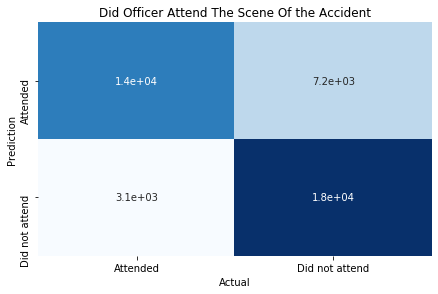

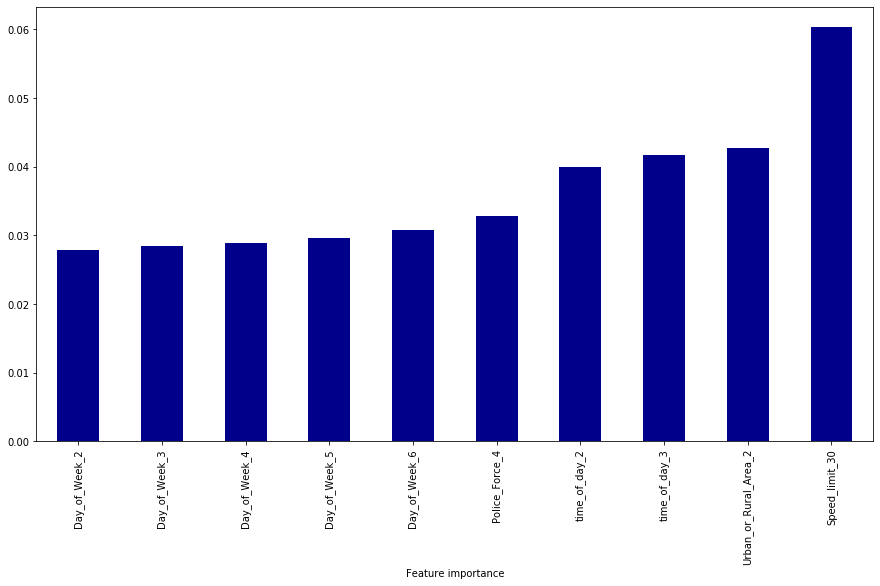

In [17]:
# create confusion matrix# create confusion matrix
matrix = confusion_matrix(y_test, y_test_preds)

# create dataframe
class_names = df_model.Did_Police_Officer_Attend_Scene_of_Accident.values
dataframe = pd.DataFrame(matrix, index=['Attended', 'Did not attend'], 
                         columns=['Attended', 'Did not attend'])

# create heatmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
plt.title('Did Officer Attend The Scene Of the Accident')
plt.tight_layout(), plt.xlabel('Actual'), plt.ylabel('Prediction')
plt.show()

# plot the important features
feat_importances = pd.Series(RFT_Model.feature_importances_, index=features.columns)
feat_importances.nlargest(10).sort_values().plot(kind='bar',  figsize=(15,8), color='darkblue')
plt.xlabel('Feature importance');

In [ ]:
# save the model to disk
if(not path.exists(filename)):
    pickle.dump(RFT_Model, open(filename, 'wb'))
else:
    print("Removing old model in favor of new one")
    os.remove(filename)
    pickle.dump(RFT_Model, open(filename, 'wb'))